In [41]:
import os 
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from sklearn.preprocessing import LabelEncoder

# Convolutional Neural Network

A diferencia del tipo de red usada en el ejercicio anterior, las redes neuronales convolucionales son conocidas por su gran éxito al trabajar sobre **imágenes**. 


<div class="alert alert-warning">
El objetivo de esta parte es tratar las imágenes obtenidas a partir del GC-IMS con este tipo de redes para clasificarlas entre las tres categorías existentes (EVOO/LOO/VOO), además de familiarizarnos con cada una de las capas que se pueden usar en este tipo de redes.
</div>

Varios aspectos a tener en cuenta:
* Para un ordenador, una imagen es una matriz de datos, donde cada píxel está representado por uno o más valores:
    * Si la matriz tiene un valor por píxel $\rightarrow$ imagen en escala de grises
    <img src="img/eight.gif" alt="Drawing" style="width: 200px;"/>
    * Si la matriz tiene tres valores por píxel $\rightarrow$ imagen a color
    <img src="img/Imagen12.png" alt="Drawing" style="width: 400;"/>



## 1. Preprocesamiento y lectura de los datos
Como vimos en la parte teórica, el preprocesamiento de los datos es una tarea fundamental a la hora de trabajar analizando datos. <br>
En redes neuronales convolucionales es muy común **normalizar** el valor de los bits a una escala entre 0 y 1 con la siguiente fórmula:

\begin{equation*}
z_i=\frac{x_i-\min(x)}{\max(x)-\min(x)}
\end{equation*}

Como en nuestro caso el mínimo es igual a cero, la fórmula quedaría de la forma siguiente:
\begin{equation*}
z_i=\frac{x_i}{\max(x)}
\end{equation*}

### A. Lectura, Redimensión y Normalización

In [4]:
# Función que nos ayudará a leer los datos y a normalizarlos
def load_training_data(directorio, label):
    X_train_data = []
    y = []
    for img in os.listdir(directorio):
        path = os.path.join(directorio, img)
        img = Image.open(path)
        img = img.convert('L')
        img = img.resize((100, 100), Image.ANTIALIAS)
        img = np.array(img)
        img = img.astype('float')
        img = img/255.0            #Para normalizar los datos
        X_train_data.append(np.array(img))
        y.append(label)
    return(X_train_data, y)

A continuación leeremos, por un lado los datos que nos servirán para entrenar la red y por otro lado aquellos que usaremos para validarla:

In [9]:
#Entrenamiento
E_train, E_t = load_training_data('./data/huella_espectral_CNN/train/E', 'E')
V_train, V_t = load_training_data('./data/huella_espectral_CNN/train/V', 'V')
L_train, L_t = load_training_data('./data/huella_espectral_CNN/train/L', 'L')

train_data = E_train.copy()
train_data.extend(V_train)
train_data.extend(L_train)

y_train = E_t.copy()
y_train.extend(V_t)
y_train.extend(L_t)

#Validación
E_validation, E_t = load_training_data('./data/huella_espectral_CNN/validation/E', 'E')
V_validation, V_t = load_training_data('./data/huella_espectral_CNN/validation/V', 'V')
L_validation, L_t = load_training_data('./data/huella_espectral_CNN/validation/L', 'L')

test_data = E_validation.copy()
test_data.extend(V_validation)
test_data.extend(L_validation)

y_test = E_t.copy()
y_test.extend(V_t)
y_test.extend(L_t)

El siguiente paso que daremos es comprobar que los datos efectivamente están normalizados, mediante un **histograma**

(array([ 567., 3077., 3576., 1065.,  288.,  171.,   79.,   86.,  215.,
         876.]),
 array([0.2627451 , 0.33647059, 0.41019608, 0.48392157, 0.55764706,
        0.63137255, 0.70509804, 0.77882353, 0.85254902, 0.92627451,
        1.        ]),
 <a list of 10 Patch objects>)

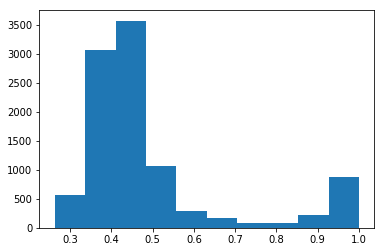

In [15]:
plt.hist(train_data[3].ravel())

## TODO: probar con otras imágenes para comprobar que no se debe al azar

### B. Label Encoder de la clase
Para que el algoritmo funcione correctamente necesitamos hacer un encodign de la variable **Clase**, cambiando los atributos categóricos por numéricos, esto se hacía con la clase **LabelEncoder()**

In [28]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [29]:
y_train

array([0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1], dtype=int64)

In [30]:
le.inverse_transform(y_train)

array(['E', 'E', 'E', 'E', 'E', 'V', 'V', 'V', 'V', 'V', 'V', 'V', 'L',
       'L', 'L', 'L', 'L'], dtype='<U1')

En resumen tenemos los siguientes datos.

* **input** $\rightarrow$ 27 muestras de aceite
    * Cada muestra tiene 1 valor por píxel (imágenes en escala de grises)
    * Cada imagen queda represntada por una matriz de tamaño $100\times 100$
* **target** $\rightarrow$ 27 enteros indicando la clase. Recordemos que 0 = E, 2 = V, 1 = L

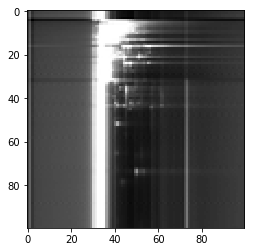

In [16]:
#Mostar una imagen
plt.imshow(train_data[0], cmap='gist_gray')

# 3. Construir la red neuronal convolucional
Recordemos que las redes neuronales convolucionales son una combinación de varios tipos de capas:
* Convolución + Activación
* Pooling
* Flatten 
* Fully Connected

En la siguiente imagen podemos ver la ide general del proceso que se realiza:
<img src="img/Imagen14.png" alt="Drawing" style="width: 400;"/>

Para refrescar un poco la memoria haremos un breve repaso sobre qué hacía cada una de las capas.
<div class="alert alert-success">
<strong>Convolución</strong>
</div>
<img src="img/convSobel.gif" alt="Drawing" style="height: 200;"/>

<div class="alert alert-success">
<strong>Función Activación</strong>
</div>
<img src="img/Imagen15.png" alt="Drawing" style="width: 200;"/>


<div class="alert alert-success">
<strong>Pooling</strong>
</div>
<img src="img/maxpool_animation.gif" alt="Drawing" style="width: 200;"/>



<div class="alert alert-success">
<strong>Flatten</strong>
</div>
<img src="img/Imagen16.png" alt="Drawing" style="width: 200;"/>


<div class="alert alert-success">
<strong>Fully Connected + Softmax</strong>
</div>
<img src="img/Imagen17.png" alt="Drawing" style="width: 200;"/>


## Forma de trabajar con Keras
La forma de trabajar con Keras siempre es la misma, tiene unos pasos muy bien definidos que hay que seguir para construir cualquier red neuronal. Estos pasos son los que se detallan en la siguiente imagen:
![title](img/Imagen18.png)



## CNN Simple
Como primera aproximación, para ponernos un poco en contexto, crearemos una CNN con sólo un tipo de cada una de las capas:
* 1 Capa de **Convolución**
* 1 Capa de **Pooling**
* 1 Capa **Flatten**
* 1 Capa **Fully Connected**


In [34]:
#Paso 1: crear el modelo
model = Sequential()

#Paso 2: Añadimos la capa de convolución e indicamos la función de activación
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(100,100,1)))

#Paso 3: Establecemos la capa de Pooling
model.add(MaxPooling2D())

#Paso 4: Establecemos la capa Flatten
model.add(Flatten())

#Paso 4: Por último añadimos la capa Fully Connected
model.add(Dense(3, activation='softmax'))

# Mostrar un resumen de la red creada
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 153664)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 460995    
Total params: 461,635
Trainable params: 461,635
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# Compilamos y entrenamos el modelo
train_data = np.array(train_data)
train_data = train_data.reshape(-1,100, 100, 1)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, y_train, epochs = 20, verbose=1)

Epoch 1/20
17/17 [==============================] - 1s 33ms/step - loss: 0.6837 - acc: 0.8235
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 0.9609 - acc: 0.4118
Epoch 3/20
17/17 [==============================] - 0s 6ms/step - loss: 0.6813 - acc: 0.7059
Epoch 4/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6067 - acc: 0.8235
Epoch 5/20
17/17 [==============================] - 0s 7ms/step - loss: 0.6596 - acc: 0.8235
Epoch 6/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5340 - acc: 0.8824
Epoch 7/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4869 - acc: 0.8824
Epoch 8/20
17/17 [==============================] - 0s 7ms/step - loss: 0.5299 - acc: 0.8235
Epoch 9/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4855 - acc: 0.8235
Epoch 10/20
17/17 [==============================] - 0s 7ms/step - loss: 0.4288 - acc: 0.8824
Epoch 11/20
17/17 [==============================] - 0s 6ms/step - l

Una vez que ya tenemos nuestro modelo entrenado debemos pasar a **evaluarlo** con los datos de test

In [40]:
test_data = np.array(test_data)
test_data = test_data.reshape(-1,100, 100, 1)
loss, acc = model.evaluate(test_data, y_test, verbose = 1)
print(acc*100)

10/10 [==============================] - 0s 11ms/step
20.000000298023224


Los malos resultados obtenidos se deben principalmente a que el conjunto de datos que hemos elegido es muy pequeño, debido a que un gran conjunto de datos necesitaría de mucha más capacidad de cómputo, tardando incluso horas y días en nuestros ordenadores

## 4. Mejorar el modelo
Como ejercicio adicional intentaremos mejorar un poco el modelo anterior, probando por ejemplo con otros optimizadores o añadiendo más capas de convolución

In [42]:
##TODO